In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Creating the Dataset

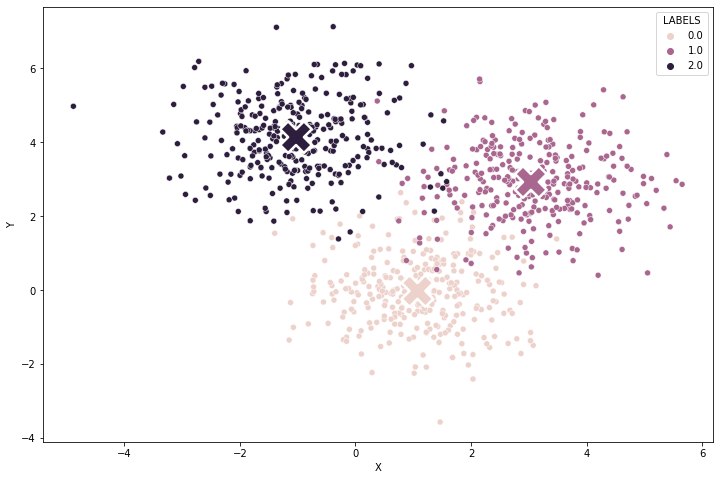

In [17]:
np.random.seed(1234)

cluster_centers = {
    0: [1, 0],
    1: [3, 3],
    2: [-1, 4]
}

N = 300

for i, (k, v) in enumerate(cluster_centers.items()):
    if not i:
        data = np.random.randn(N, 2) + np.reshape(np.array(v), newshape=(1, -1))
        labels = np.reshape(np.array([k] * N), newshape=(-1, 1))
    else:
        data = np.concatenate((data, np.random.randn(N, 2) + np.reshape(np.array(v), newshape=(1, -1))), axis=0)
        labels = np.concatenate((labels, np.reshape(np.array([k] * N), newshape=(-1, 1))), axis=0)
        
df = pd.DataFrame(data=np.concatenate((data, labels), axis=1), columns=['X', 'Y', 'LABELS'])
centroids = df.groupby('LABELS', as_index=False).agg(x_mean=('X', 'mean'), y_mean=('Y', 'mean'))
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df, x='X', y='Y', hue='LABELS', ax=ax, marker='o')
sns.scatterplot(data=centroids, x='x_mean', y='y_mean', hue='LABELS', ax=ax, marker='X', s=1000, legend=None)
plt.show()

### Hard K-Means

Total Loops: 22


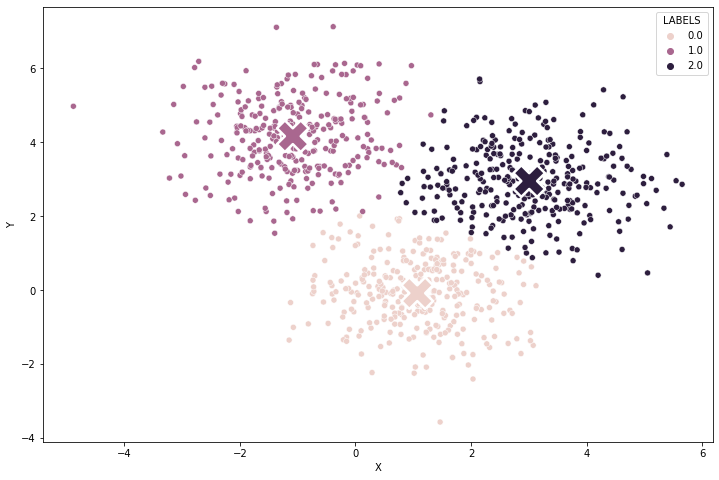

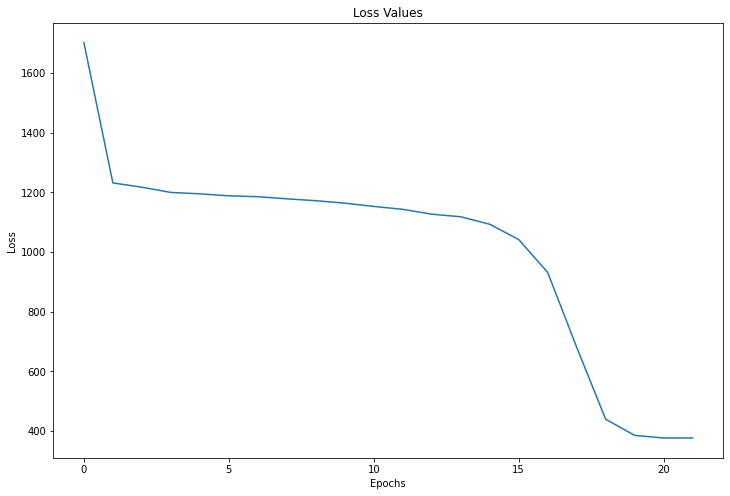

In [4]:
np.random.seed(1234)
K = 3
counter = 0
means = data[np.random.randint(data.shape[0], size=K), :] # Selecionando centros arbitrários
key = True
loss = []
while key:
    new_label = []
    for r in data:
        new_label.append(np.argmin(np.sqrt(np.sum(np.power(r - means, 2), axis=1))))
    
    for k in np.unique(new_label):
        ind_loss = np.sqrt(np.sum(np.power(data[new_label == k] - means[k], 2), axis=1))
    loss.append(np.sum(ind_loss))
    
    new_means = []
    for l in np.unique(new_label): # Recalculando as os centros
        new_means.append(np.mean(data[new_label==l], axis=0))
    new_means = np.array(new_means)
    
    if np.all(means == new_means):
        key = False
    means = new_means
    counter += 1
print(f'Total Loops: {counter}')
    
new_label = np.reshape(new_label, newshape=(-1, 1))
df = pd.DataFrame(data=np.concatenate((data, new_label), axis=1), columns=['X', 'Y', 'LABELS'])    
centroids = pd.DataFrame(data=np.concatenate((means, np.unique(new_label).reshape((-1, 1))), axis=1), columns=['x_mean', 'y_mean', 'LABELS'])
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df, x='X', y='Y', hue='LABELS', ax=ax, marker='o')
sns.scatterplot(data=centroids, x='x_mean', y='y_mean', hue='LABELS', ax=ax, marker='X', s=1000, legend=False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=loss, ax=ax)
plt.title('Loss Values')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

### Soft K-Means

Total Loops: 122


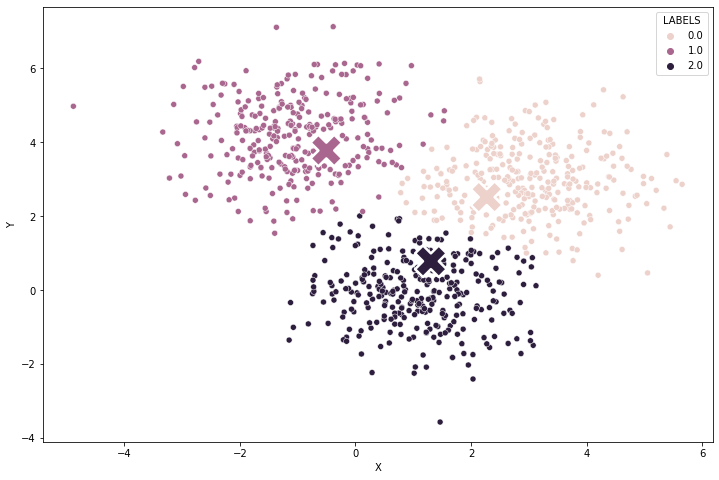

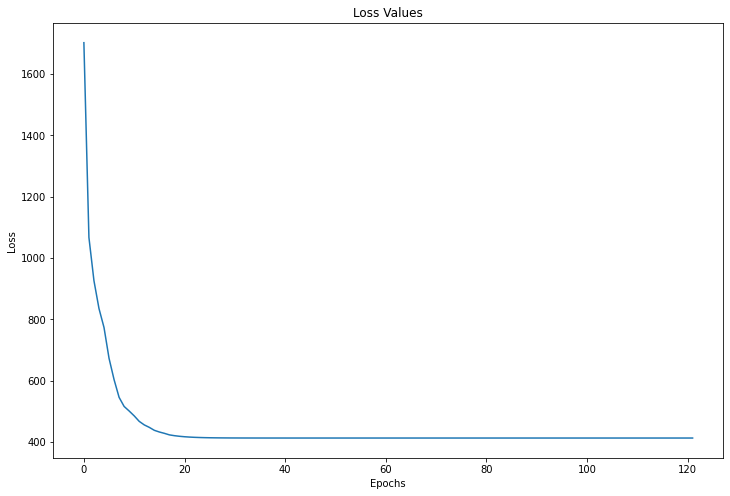

In [15]:
np.random.seed(1234)

def get_responsibilities(X, means, beta=1.0):
    R = np.zeros(shape=(X.shape[0], means.shape[0]))
    for i, x in enumerate(X):
        dist = np.sqrt(np.sum(np.power(x - means, 2), axis=1))
        r = np.exp(-dist * beta)/np.sum(np.exp(-dist * beta))
        R[i] = r
    return R

K = 3
counter = 0
key = True
means = data[np.random.randint(data.shape[0], size=K), :] # Selecionando centros arbitrários
max_iter = 200
loss = []
while key and counter < max_iter:
    new_label = []
    for r in data:
        new_label.append(np.argmin(np.sqrt(np.sum(np.power(r - means, 2), axis=1))))
    
    for k in np.unique(new_label):
        ind_loss = np.sqrt(np.sum(np.power(data[new_label == k] - means[k], 2), axis=1))
    loss.append(np.sum(ind_loss))
    
    new_means = []
    r = get_responsibilities(X=data, means=means, beta=0.8) # Calculando as reponsibilidades 
    for l in np.unique(new_label): # Recalculando as os centros
        new_means.append(r[:, l].dot(data)/r[:, l].sum())
    new_means = np.array(new_means)
    
    if np.all(means == new_means):
        key = False
    means = new_means
    counter += 1
print(f'Total Loops: {counter}')
    
new_label = np.reshape(new_label, newshape=(-1, 1))
df = pd.DataFrame(data=np.concatenate((data, new_label), axis=1), columns=['X', 'Y', 'LABELS'])    
centroids = pd.DataFrame(data=np.concatenate((means, np.unique(new_label).reshape((-1, 1))), axis=1), columns=['x_mean', 'y_mean', 'LABELS'])
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df, x='X', y='Y', hue='LABELS', ax=ax, marker='o')
sns.scatterplot(data=centroids, x='x_mean', y='y_mean', hue='LABELS', ax=ax, marker='X', s=1000, legend=False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=loss, ax=ax)
plt.title('Loss Values')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

### Soft K-Means Classifier

In [80]:
class SoftKMeans():
    
    def __init__(self, K=3, beta=1.0, max_iter=100):
        self.K = K
        self.beta = beta
        self.max_iter = max_iter
        self.centers = []
        
    
    def get_responsibilities(self, X, centers, beta):
        R = np.zeros(shape=(X.shape[0], centers.shape[0]))
        for i, x in enumerate(X):
            dist = np.sqrt(np.sum(np.power(x - centers, 2), axis=1))
            r = np.exp(-dist * beta)/np.sum(np.exp(-dist * beta))
            R[i] = r
        return R
    
    
    def fit(self, X):
        assert isinstance(X, np.ndarray), 'The input must be a Numpý array.'
        assert X.ndim == 2, 'The input must be a 2D array.'
        counter = 0
        key = True
        self.loss = []
        centers = X[np.random.randint(X.shape[0], size=self.K), :] # Selecionando centros arbitrários
        
        while key and counter < self.max_iter:
            labels = []
            for x in X:
                labels.append(np.argmin(np.sqrt(np.sum(np.power(x - centers, 2), axis=1))))

            for k in np.unique(labels):
                ind_loss = np.sqrt(np.sum(np.power(X[labels == k] - centers[k], 2), axis=1))
            self.loss.append(np.sum(ind_loss))

            new_centers = []
            r = self.get_responsibilities(X=X, centers=centers, beta=self.beta) # Calculando as reponsibilidades 
            for k in np.unique(labels): # Recalculando as os centros
                new_centers.append(r[:, k].dot(X)/r[:, k].sum())
            new_centers = np.array(new_centers)

            if np.all(centers == new_centers):
                key = False
            centers = new_centers
            counter += 1
        
        if key:
            print(f'The model exceeded the max_iter param.')
        else:
            print(f'The model converged after {counter} iterations.')
        
        self.centers = centers
        
        
    def transform(self, X):
        labels=[]
        for x in X:
            labels.append(np.argmin(np.sqrt(np.sum(np.power(x - self.centers, 2), axis=1))))
        return np.array(labels).reshape(-1, 1)
    
    
    def score(self, X, target):
        assert isinstance(target, np.ndarray)
        assert target.ndim == 2
        assert target.shape[1] == 1
        labels = self.transform(X)
        return labels[labels == target].shape[0]/target.shape[0]

The model exceeded the max_iter param.


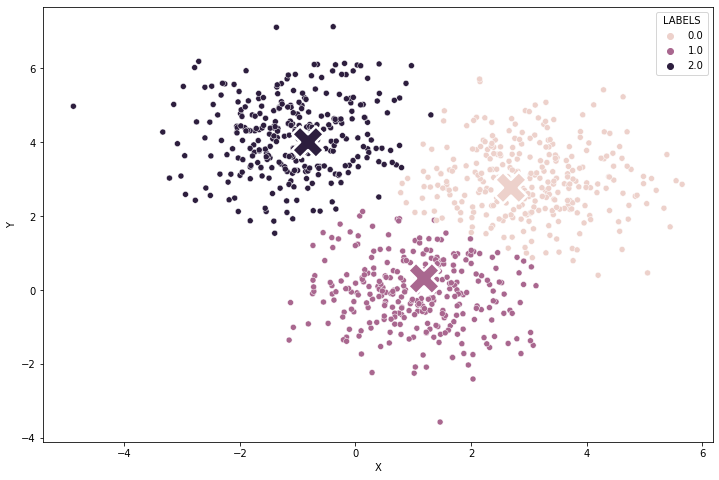

In [81]:
kmeans = SoftKMeans(K=3, max_iter=200)
kmeans.fit(data)

new_label = kmeans.transform(data)
df = pd.DataFrame(data=np.concatenate((data, new_label), axis=1), columns=['X', 'Y', 'LABELS'])    
centroids = pd.DataFrame(data=np.concatenate((kmeans.centers, np.unique(new_label).reshape((-1, 1))), axis=1), columns=['x_mean', 'y_mean', 'LABELS'])
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df, x='X', y='Y', hue='LABELS', ax=ax, marker='o')
sns.scatterplot(data=centroids, x='x_mean', y='y_mean', hue='LABELS', ax=ax, marker='X', s=1000, legend=False)
plt.show()